## Draft: exploring *accessibleAt* property for Tools and Services in the MarketPlace Dataset 

This notebook discovers wrong URL values (if any) in the *accessibleAt* property for Tools and Services. 



In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Function to download descriptions from the MarketPlace dataset using the API
In the final release of this Notebook this function will be (possibly) optimized and provided as an external library.

In [2]:
def getMPDescriptions (url, pages):
    mdx = pd.Series(range(1, pages+1))
    df_desc = pd.DataFrame()
    for var in mdx:
        turl = url+str(var)+"&perpage=20"
        df_desc_par=pd.read_json(turl, orient='columns')
        df_desc=df_desc.append(df_desc_par, ignore_index=True)
        
    return (df_desc)

### 1 - Get the the descriptions of Tools and Services

In [3]:
df_tool_all = pd.DataFrame()
df_tool_all =getMPDescriptions ("https://sshoc-marketplace-api.acdh-dev.oeaw.ac.at/api/tools-services?page=", 81)
df_tool_all.index

RangeIndex(start=0, stop=1606, step=1)

#### A quick look at data
The table below shows information about few, randomly chosen, descriptions.  
Only a subset of values are shown, in particular: *id, category, label, licenses, contributors, accessibleAt, sourceItemId*.  

In [5]:
df_tool_flat = pd.json_normalize(df_tool_all['tools'])
df_tool_work=df_tool_flat[['id', 'category', 'label', 'licenses', 'contributors', 'accessibleAt', 'sourceItemId']]
df_tool_work.head()

,id,category,label,licenses,contributors,accessibleAt,sourceItemId
0,30509,tool-or-service,140kit,[],"[{'actor': {'id': 483, 'name': 'Ian Pearce, De...",[https://github.com/WebEcologyProject/140kit],937
1,28542,tool-or-service,3DF Zephyr - photogrammetry software - 3d mode...,[],[],[https://www.3dflow.net/3df-zephyr-pro-3d-mode...,WQFP6XPS
2,11508,tool-or-service,3DHOP,[],[],[http://vcg.isti.cnr.it/3dhop/],SG86ZG5J
3,11419,tool-or-service,3DHOP: 3D Heritage Online Presenter,[],[],[https://github.com/cnr-isti-vclab/3DHOP],R379NADX
4,11507,tool-or-service,3DReshaper \| 3DReshaper,[],[],[https://www.3dreshaper.com/en/],PMES8DJW


### 2 - Check values in *AccessibleAT*
To check URLs we first define a dataset with three columns: *id, label, AccessibleAt* (see table below for example).

In [7]:
df_temp_tool_work=df_tool_work[['id','label','accessibleAt']]
df_temp_tool_work.sort_values('accessibleAt').tail()

,id,label,accessibleAt
1574,29097,XGLab - X and Gamma Ray Electronics,[https://www.xglab.it/]
767,11359,Mesh Optimization Using MeshLab - 3dmotive,[https://www.youtube.com/watch?v=gWBm5XGRJOk]
1596,29546,ZeeMaps,[https://www.zeemaps.com/]
1598,29726,ZingChart,[https://www.zingchart.com/]
1599,29638,Zoho,[https://www.zoho.com/crm/?network=g&device=c&...


#### Check if there are empty values

In [11]:
df_tool_work_emptyurls=df_tool_work[df_tool_work['accessibleAt'].str.len()==0]
emptyurldescriptionsn=df_tool_work_emptyurls.count()[0]
print(f'\n There are {emptyurldescriptionsn} tools/services descriptions without corresponding accessibleAt URLs\n')


 There are 507 tools/services descriptions without corresponding accessibleAt URLs



#### Check the validity of URLs in the *AccessibleAt* property using the HTTP Result Status
The code below explicitly execute an http call for every URL, waits for the [Result Status Code](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)  of the call and then registers the code.  
Depending on connections and server answer times it may take several minutes to process all URLs.  
In the final release of this Notebook this code will be (possibly) optimized and provided as an external library.

In [43]:
df_tool_work=df_tool_work.explode('accessibleAt')

In [52]:
df_tool_work_urls=df_tool_work[df_tool_work['accessibleAt'].str.len()>0]
df_urls=df_tool_work_urls['accessibleAt'].values
df_tool_work_aa_http_status = pd.DataFrame (columns = ['url','status'])
import requests
import re
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
for var in df_urls:
    if ( var != "" and var!=None and re.match(regex, var)):
        try:
            r =requests.get(var,timeout=8)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(r.status_code)}, ignore_index=True)
        except requests.exceptions.ConnectionError:
          #  print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(503)}, ignore_index=True)
        except requests.exceptions.ConnectTimeout:
          #  print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.ReadTimeout:
         #   print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(408)}, ignore_index=True)
        except requests.exceptions.RequestException:
         #   print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(500)}, ignore_index=True)
        except TypeError:
        #    print(var)
            df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
    else:
       # print(var ,0)
        df_tool_work_aa_http_status = df_tool_work_aa_http_status.append({'url': var, 'status': int(400)}, ignore_index=True)
df_tool_work_aa_http_status.head()

,url,status
0,https://github.com/WebEcologyProject/140kit,200
1,https://www.3dflow.net/3df-zephyr-pro-3d-model...,200
2,http://vcg.isti.cnr.it/3dhop/,200
3,https://github.com/cnr-isti-vclab/3DHOP,200
4,https://www.3dreshaper.com/en/,200


In [53]:
df_http_status_sub=df_tool_work_aa_http_status[df_tool_work_aa_http_status['status'] != 1]
df_db_st = df_http_status_sub['status'].value_counts()
print('{:<8}Frequency'.format("Status"))
df_db_st.head(10)

Status  Frequency


200    1088
404     100
503      37
403      14
406      10
500       4
408       4
502       2
420       2
400       1
Name: status, dtype: int64

The first column in the table above shows the HTTP Status codes obtained when trying to connect on *accessibleAt* URLs, the second column the total number of URLs returning the status.
Notice that while 404 means that the resource is not found, other status codes may indicate temporary problems.  
The image below summarizes of the above result.

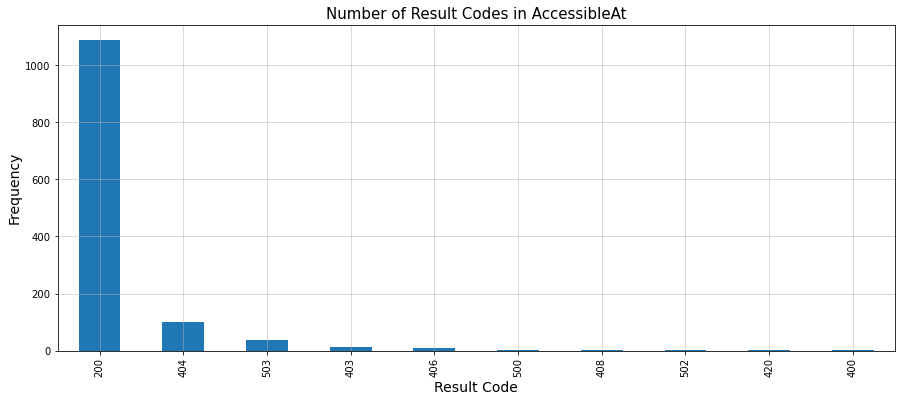

In [54]:
fig, ax = plt.subplots()
df_db_st.plot(kind='bar', figsize=(15,6), x='Status', y='Frequency',)
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of Result Codes in AccessibleAt", fontsize=15)
ax.set_xlabel('Result Code', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14);
plt.show()

### 3 - Save results
The list of possibly wrong url is saved in a Comma Separated Values (CSV) file having the following columns: *id, label, url, status*. The final release of the notebook will save this data in the curation dataset.

In [55]:
df_http_status_err=df_http_status_sub[df_http_status_sub['status'] != 200]
df_list_of_tools_wrongaa=pd.merge(left=df_tool_work, right=df_http_status_err, left_on='accessibleAt', right_on='url')
df_list_of_tools_wrongaa.head()
df_list_of_tools_wrongaa[['id', 'label', 'url', 'status']].sort_values('id').to_csv(path_or_buf='ts_wrongurls.csv')